In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import os
import datetime
import time

In [3]:
import itertools

In [4]:
from slack_data_loader import SlackLoader

In [5]:
plt.figure(figsize=(10, 10))
SECS_IN_DAY = 60 * 60 * 24

In [6]:
# this class wrap time by daily activity distribution 
class TimeDistance:
    
    def calc_dist(self, times):
        day_times = times % SECS_IN_DAY
        hist, ranges = np.histogram(day_times, range=(0, SECS_IN_DAY), bins=self.bins)
        total_count = hist.sum()
        normalized_hist = hist / self.total_count
        ranges = ranges.astype(int)[:-1]
        dist = dict(zip(ranges, normalized_hist))
        mean = normalized_hist.mean()
        return (mean, dist)
    
    
    def get_time_range(self, ts):
        dt = datetime.datetime.fromtimestamp(ts)
        return str(dt.year) + str(int(dt.month / 6))
    
    def init_distribution(self, times):
        # split by years somehow
        self.bins = 100
        self.time_step = int(SECS_IN_DAY / self.bins)
        self.total_count = times.size
        
        datetimes = map(self.get_time_range, times)
        zp = zip(datetimes, times)
        grps = itertools.groupby(zp, key=lambda x: x[0])

        time_groups = list([ (k, np.array([y for x,y in g]) ) for k,g in grps])
        
        meanes = []
        dists = []
        for key, group_times in time_groups:
            mean, dist = self.calc_dist(group_times)
            meanes.append( (key, mean) )
            dists.append( (key, dist) )
        
        self.dist = dict(dists)
        self.mean = dict(meanes)
        
        return self
    
    def get_range_start(self, ts):
        return int(ts % SECS_IN_DAY / self.time_step) * self.time_step
    
    def get_dist(self, ts):
        curr_range = self.get_range_start(ts)
        return self.dist[self.get_time_range(ts)][curr_range]
    
    def get_mean(self, ts):
        return self.mean[self.get_time_range(ts)]
        
    def distance(self, ts1, ts2):
        max_ts = max(ts1, ts2)
        min_ts = min(ts1, ts2)
        curr = min_ts
        dist = 0.0
        diff = max_ts - min_ts
        if diff > SECS_IN_DAY:
            secs = int(diff / SECS_IN_DAY) * SECS_IN_DAY
            dist += secs * self.get_mean(curr)
            curr += secs
        while curr < max_ts:
            time_to_next_range = self.time_step - curr % self.time_step
            time_to_end = max_ts - curr
            min_time = min(time_to_end, time_to_next_range)
            curr += min_time
            dist += self.get_dist(curr) * min_time
        return dist

In [23]:
class Chunker:
    def split_by_threshold(self, difs, threshold):
        res = []
        start = 0
        curr = difs
        while len(curr) > 0:
            group_len = len(list(itertools.takewhile(lambda x: x < threshold, curr)))
            res.append(range(start, start + group_len + 1))
            curr = curr[group_len + 1:]
            start = start + group_len + 1
        return res

    def cluster_time_series(self, timeObj, times, threshold = 100.0):
        time_difs = np.zeros(times.size - 1)
        for i in range(0, times.size - 2):
            time_difs[i] = timeObj.distance(times[i], times[i + 1])
        chunks = self.split_by_threshold(time_difs, threshold)
        return chunks
    
    def merge_with_threads(self, chunks, threads):
        for thread in threads:
            chunks = list(filter(lambda x: not (x[0] <= thread[0] <= x[-1] or x[0] <= thread[-1] <= x[-1]), chunks))
        chunks += threads
        return sorted(chunks, key=lambda x: x[0])

In [8]:
data = SlackLoader('data', only_channels=['nlp'])

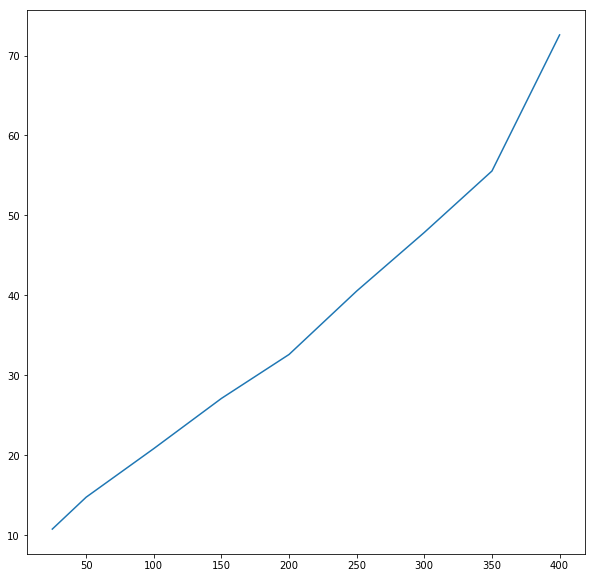

In [9]:
times = np.array(list(map(lambda x: x['ts'], data.messages)))
timeObj = TimeDistance().init_distribution(times)
chunker = Chunker()


length = []
thresholds = [400, 350 ,300, 250, 200, 150, 100, 50, 25]
for threshold in thresholds:
    # [1,2,3,4,105,106,107,108] -(chunking)-> [[0,1,2,3], [4,5,6,7]]
    chunks = chunker.cluster_time_series(timeObj, times, threshold)
    length.append( np.array(list(map(len, chunks))).mean())


plt.plot(thresholds, length)
plt.show()

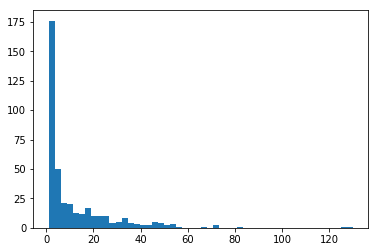

In [10]:
chunks = chunker.cluster_time_series(timeObj, times, threshold=30)
chunk_lengthes = np.array(list(map(len, chunks)))

plt.hist(chunk_lengthes, bins=50)
plt.show()

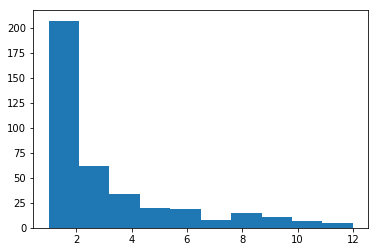

In [11]:
uniq_user_count_per_chunk = []
for chunk in chunks:
    users = []
    for i in chunk:
        users.append(data.messages[i]['user'])
    uniq_user_count_per_chunk.append(len(set(users)))

plt.hist(uniq_user_count_per_chunk)
plt.show()

In [20]:
threads = data.find_threads()
chunker.merge_with_threads()

In [21]:
chunks

[range(0, 16),
 range(16, 61),
 range(61, 79),
 range(79, 93),
 range(93, 103),
 range(103, 146),
 range(146, 148),
 range(148, 160),
 range(160, 178),
 range(178, 179),
 range(179, 200),
 range(200, 250),
 range(250, 284),
 range(284, 285),
 range(285, 287),
 range(287, 360),
 range(360, 363),
 range(363, 365),
 range(365, 368),
 range(368, 383),
 range(383, 391),
 range(391, 398),
 range(398, 399),
 range(399, 400),
 range(400, 415),
 range(415, 418),
 range(418, 419),
 range(419, 423),
 range(423, 429),
 range(429, 459),
 range(459, 479),
 range(479, 481),
 range(481, 564),
 range(564, 568),
 range(568, 569),
 range(569, 581),
 range(581, 592),
 range(592, 595),
 range(595, 597),
 range(597, 600),
 range(600, 601),
 range(601, 731),
 range(731, 732),
 range(732, 734),
 range(734, 737),
 range(737, 749),
 range(749, 768),
 range(768, 793),
 range(793, 807),
 range(807, 814),
 range(814, 853),
 range(853, 861),
 range(861, 865),
 range(865, 874),
 range(874, 895),
 range(895, 896),
 r

In [22]:
for chunk in chunks[:20]:
    msg = data.messages[chunk[0]]
    print(data.users[msg["user"]]['real_name'] + ": " + msg['text'] + " at " + msg['dt'].strftime("%Y-%m-%d %H:%M:%S") )
    print("......")
    msg = data.messages[chunk[-1]]
    print(data.users[msg["user"]]['real_name'] + ": " + msg['text'] + " at " + msg['dt'].strftime("%Y-%m-%d %H:%M:%S") )
    print("")
    print("------------------------------------------------------")
    print("")
    

Max Kharchenko: кстати, коль ильдар вбросил в другом чятике <http://www.yelp.com/dataset_challenge|http://www.yelp.com/dataset_challenge> . Можно попробовать потрогать NLP часть по предикшену рейтинга по ревью at 2015-05-06 14:55:47
......
Petr Ermakov: но это все ИМХО больше at 2015-05-06 15:20:46

------------------------------------------------------

Philipp Upravitelev: коллеги, возникла задача - научиться определять семантическую близость двух поисковых запросов (плюс выводить в результате степень близости, наличие одинаковых слов, наличие синонимов и так далее). что думаете, как пилить сие? датасет под сотню миллионов запросов at 2015-05-08 19:01:50
......
Petr Ermakov: <@U041SH27M>: иногда проскакивает at 2015-05-09 13:40:59

------------------------------------------------------

i: тут в ленте пролетело
<http://research.microsoft.com/en-us/downloads/731572aa-98e4-4c50-b99d-ae3f0c9562b9/default.aspx> at 2015-05-11 19:40:33
......
i: &gt; Несколько месяцев назад на базе NLPub м